In [ ]:
### Train an RL agent using DQN architecture in a Unity environment (bananaModel)

In [ ]:
from unityagents import UnityEnvironment
import numpy as np
import matplotlib.pyplot as plt
from collections import deque, defaultdict
import time
import sys
from tqdm import tqdm
from dqnetwork import DQNetwork
from agent import Agent
import torch
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
env = UnityEnvironment(file_name="Banana.app")

In [ ]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### Action space:
- `0` - walk forward 
- `1` - walk backward
- `2` - turn left
- `3` - turn right

### State space:
- `37` - dimensions.
- some samples include the agent's velocity.
- ray-based perception in the forward direction of the agent.

### Reward:

- `+1` - Yellow Banana collected.
- `-1` - Blue Banana collected.

In [ ]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents in the environment
print('Number of agents:', len(env_info.agents))

# number of actions
action_size = brain.vector_action_space_size
print('Number of actions:', action_size)

# examine the state space 
state = env_info.vector_observations[0]
print('States look like:', state)
state_size = len(state)
print('States have length:', state_size)

In [ ]:
# env_info = env.reset(train_mode=False)[brain_name] # reset the environment
# state = env_info.vector_observations[0]            # get the current state
# score = 0                                          # initialize the score
# i = 0
# while True:
#     i+=1
#     action = np.random.randint(action_size)        # select an action
#     env_info = env.step(action)[brain_name]        # send the action to the environment
#     next_state = env_info.vector_observations[0]   # get the next state
#     reward = env_info.rewards[0]                   # get the reward
#     done = env_info.local_done[0]                  # see if episode has finished
#     score += reward                                # update the score
#     state = next_state                             # roll over the state to next time step
#     if(reward != 0):
#         print(reward)
#     if done:                                       # exit loop if episode finished
#         break
    
# print("Score: {}".format(score))
# print("iterations:",i)

In [ ]:
model = DQNetwork()

In [ ]:
### DEFINE CONSTANTS

In [ ]:
BUFFER_SIZE = int(1e5)  # replay buffer size
BATCH_SIZE = 64         # minibatch size
GAMMA = 0.99            # discount factor
TAU = 1e-3              # for soft update of target parameters
LR = 5e-4               # learning rate 
UPDATE_EVERY = 4        # how often to update the network

In [ ]:
agent = Agent()

### Implement DQN Agent

In [30]:
scores = []  # List with all scores per episode
NUM_EPISODES = 300
ENV_SOLVED = 13 #How many Bananas must be collected to succeed?

In [31]:
def get_epsilon_i(num_episode, epsilon_min = 0.01):
    """Simple Epsilon Decay over total number of episodes. Stochastic in nature when summed over"""
    epsilon = 1.0/num_episode
    return max(epsilon, epsilon_min)

In [32]:
for epoch in range(1, NUM_EPISODES + 1):
    env_info = env.reset(train_mode=True)[brain_name]  # reset the environment
    state = env_info.vector_observations[0]            # get the current state
    score = 0     # initialize the score
    i = 0
    while True:
        i += 1
        epsilon = get_epsilon_i(epoch)
        action = agent.get_action(state, epsilon)        # select an action
        env_info = env.step(action)[brain_name]        # send the action to the environment
        next_state = env_info.vector_observations[0]   # get the next state
        reward = env_info.rewards[0]                   # get the reward
        done = env_info.local_done[0]                  # see if episode has finished
        transition = (state, action, reward, next_state, done) #set transition
        agent.step(transition)                         # Train the model
        score += reward                                # update the score
        state = next_state                             # roll over the state to next time step
        if done:                                       # exit loop if episode finished
            break
    scores.append(score)
    if(epoch%10 == 0):
        print(f"{epoch}: Score: {score}; Last ten mean: {np.mean(scores[-10:])}; Epsilon: {epsilon}")
    if(np.mean(scores[-10:]) >= ENV_SOLVED):
        print(f"Solved at episode {epoch} with score: {score}")
        break

10: Score: 6.0; Last ten mean: 4.4; Epsilon: 0.1
20: Score: 9.0; Last ten mean: 8.3; Epsilon: 0.05
30: Score: 10.0; Last ten mean: 7.7; Epsilon: 0.03333333333333333
40: Score: 5.0; Last ten mean: 7.5; Epsilon: 0.025
50: Score: 9.0; Last ten mean: 10.5; Epsilon: 0.02
60: Score: 9.0; Last ten mean: 10.1; Epsilon: 0.016666666666666666
70: Score: 7.0; Last ten mean: 9.4; Epsilon: 0.014285714285714285
80: Score: 3.0; Last ten mean: 10.8; Epsilon: 0.0125
90: Score: 11.0; Last ten mean: 11.7; Epsilon: 0.011111111111111112
100: Score: 17.0; Last ten mean: 13.1; Epsilon: 0.01
Solved at episode 100 with score: 17.0


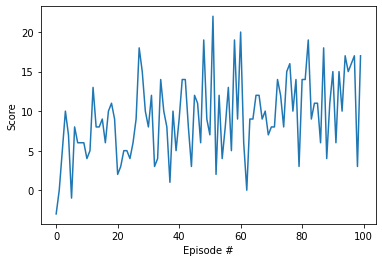

In [33]:
plt.plot(scores)
plt.xlabel("Episode #")
plt.ylabel("Score")
plt.show()

## Test an Agent

In [42]:
import time
time.sleep(15)

In [44]:
env_info = env.reset(train_mode=False)[brain_name] # reset the environment
state = env_info.vector_observations[0]            # get the current state
score = 0                                          # initialize the score
i = 0
solved_at = False
while True:
    i+=1
    action = agent.get_action(state, epsilon)        # select an action
    env_info = env.step(action)[brain_name]        # send the action to the environment
    next_state = env_info.vector_observations[0]   # get the next state
    reward = env_info.rewards[0]                   # get the reward
    done = env_info.local_done[0]                  # see if episode has finished
    score += reward                                # update the score
    state = next_state                             # roll over the state to next time step
    if(score >= ENV_SOLVED and solved_at == False):
        solved_at = True
        print(f"Solved at iteration: {i}")
    if done:                                       # exit loop if episode finished
        break
    
print("Score: {}".format(score))
print("iterations:",i)

Solved at iteration: 178
Score: 23.0
iterations: 300


# Save model

In [37]:
#Save model:
torch.save(agent.qnetwork_local.state_dict(), './model/local_model.pth')

In [38]:
#---OPTIONAL---
#Load model:
import os
# load the weights from file
agent.qnetwork_local.load_state_dict(torch.load( os.path.join('./model/local_model.pth'), map_location='cpu'))
agent.qnetwork_local.eval()

DQNetwork(
  (fc1): Linear(in_features=37, out_features=128, bias=True)
  (dp1): Dropout(p=0.3, inplace=False)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (dp2): Dropout(p=0.1, inplace=False)
  (fc3): Linear(in_features=64, out_features=32, bias=True)
  (fc4): Linear(in_features=32, out_features=4, bias=True)
)